# NorESM at Zeppelin

In [16]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Importing necessary libraries and functions

import xarray as xr
from sizedist_utils import compute_Nx_ebas_cleaned
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022')

['escience2022/Ada',
 'escience2022/Antoine',
 'escience2022/Dominic',
 'escience2022/ESA_SMOS_sss',
 'escience2022/Remy',
 'escience2022/Sara',
 'escience2022/Zhihong']

## Load and prepare data

### Zeppelin station

In [18]:
# Zeppelin data

data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')

In [61]:
# Wave your cloud flag

data1_cl_mask=data1.where(data1['cloud_flag']=='yes')
data1_no_cl = data1.where(data1['cloud_flag']=='no')

In [62]:
data1

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... 2...
    cloud_flag                                     (time) object 'yes' ... 'no'
    enrichment_factor                              (time) float64 10.82 ... 1.0
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    temperature                                    (time) float64 -6.659 ... ...
    wind_direction                                 (time) float64 130.2 ... 1...
    wind_speed                                     (time) float64 9.748 ... 1...
    updraft_velocity                               (time) float64 4.506 ... 4...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

### NorESM data

In [21]:
# Pick variables

varl = ['N100','N200','N50'] 

In [22]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

In [23]:
def make_file_path_for_var(v,):
    return path_to_data+v+postfix

In [24]:
filelist = [make_file_path_for_var(v) for v in varl]

In [25]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

ds

<xarray.Dataset>
Dimensions:   (lev: 32, time: 26352, location: 5)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 2015-01-01 ... 2018-01-02T23:00:00
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
Data variables:
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N200      (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>

In [26]:
ds.sel(location='Zeppelin').time

<xarray.DataArray 'time' (time: 26352)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000', ..., '2018-01-02T21:00:00.000000000',
       '2018-01-02T22:00:00.000000000', '2018-01-02T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01 ... 2018-01-02T23:00:00
    location  <U8 'Zeppelin'
Attributes:
    long_name:  time
    bounds:     time_bnds

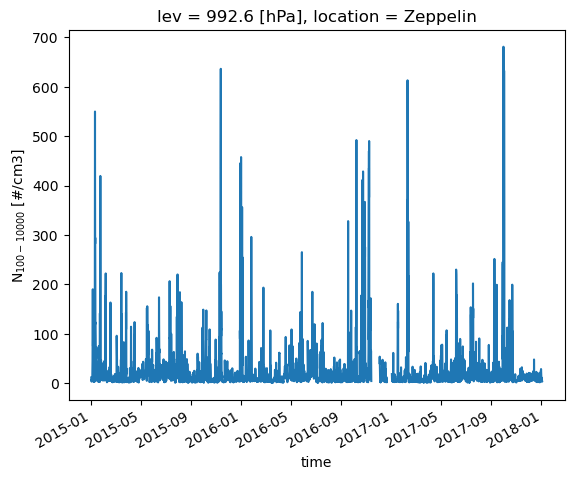

In [27]:
Nx_NorESM_N100_srf=ds.isel(lev=-1).sel(location='Zeppelin')['N100'].plot()

In [30]:
#dss = ds.sel(time = slice('1990-01-01','2010-01-01'))

#Nx_NorESM_N100_srf_Ztime=Nx_NorESM_N100_srf.resample(time='M').mean()#.sel(time = slice('

### NorESM cloud properties

In [31]:
varl = ['AWNC', 'AREL', 'FREQL', 'N100','N50'] 

In [32]:
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

In [33]:
def make_file_path_for_var(v,):
    return path_to_data+v+postfix

In [34]:
filelist = [make_file_path_for_var(v) for v in varl]

In [35]:
list_of_s3_obj = [s3.open(s) for s in filelist]

ds = xr.open_mfdataset(list_of_s3_obj)

ds

<xarray.Dataset>
Dimensions:   (lev: 32, time: 26352, location: 5)
Coordinates:
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 2015-01-01 ... 2018-01-02T23:00:00
  * location  (location) object 'Puijo' 'Zeppelin' ... 'Pallas' 'Jungfraujoch'
Data variables:
    AREL      (location, time, lev) float32 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    AWNC      (location, time, lev) float32 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    FREQL     (location, time, lev) float32 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N100      (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>
    N50       (location, time, lev) float64 dask.array<chunksize=(5, 26352, 32), meta=np.ndarray>

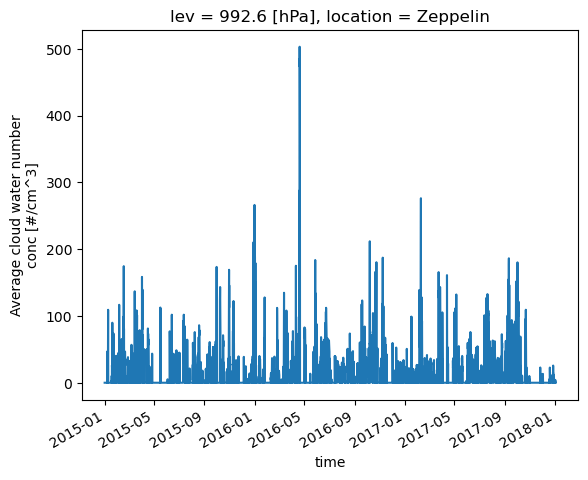

In [36]:
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC'].plot()

## Zeppelin droplet number concentration

In [37]:
data1_cl_mask

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 29.39 ... nan
    cloud_flag                                     (time) object 'yes' ... nan
    enrichment_factor                              (time) float64 10.82 ... nan
    transmission_efficiency_factor                 (time) float64 2.796 ... nan
    cluster                                        (time) float64 2.0 ... nan
    ...                                             ...
    temperature                                    (time) float64 -6.659 ... nan
    wind_direction                                 (time) float64 130.2 ... nan
    wind_speed                                     (time) float64 9.748 ... nan
    updraft_velocity                               (time) float64 4.506 ... nan
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

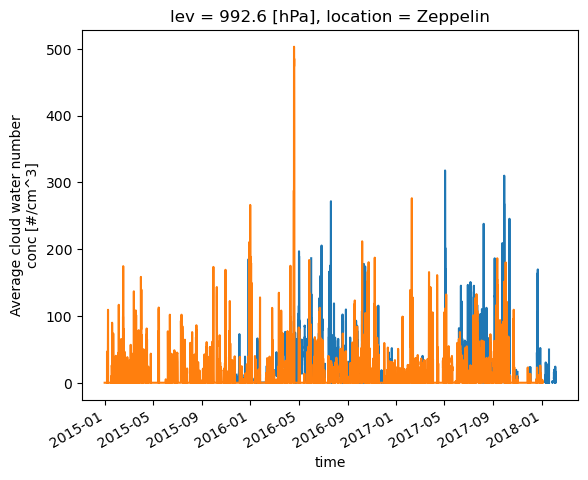

In [38]:
# Cloud droplet number concentration, with cloud particle size distribution from Fog monitor

Nx_cloud =compute_Nx_ebas_cleaned(data1_cl_mask,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloud.plot()
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC'].plot()

## Histogram: Cloud droplet number, different levels

In [39]:
ds['AWNC_incld'] = ds['AWNC']/ds['FREQL']

In [ ]:
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
ds.isel(lev=-2).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3, 50), alpha=.5, density = True)
ds.isel(lev=-3).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5 , density = True)
plt.xscale('log')
plt.xlim([0.1,400])

## Histogram: droplet number, zeppelin vs NorESM

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

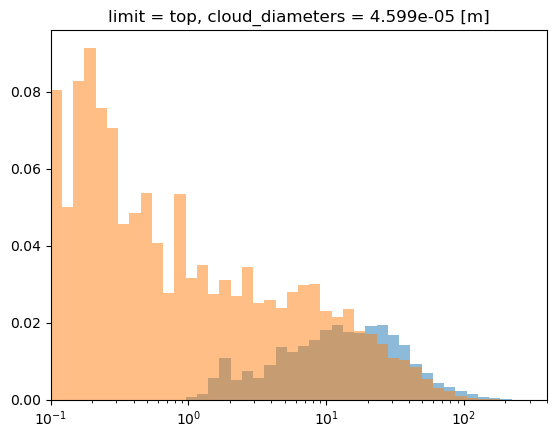

In [40]:
#resampling obs to hourly data
Nx_cloud_hourly=Nx_cloud.resample(time='H').mean()


#Plotting histograms of NorESM incloud droplet number and cloudmasked fogmonitor droplet number
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
Nx_cloud_hourly.plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
plt.xscale('log')
plt.xlim([0.1,400])

### Icefree clouds

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

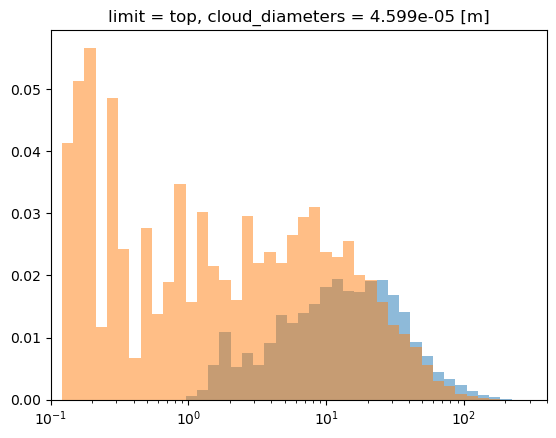

In [41]:
# Select where T > -4 from measurements, to remove ice
Nx_cloud_icefree=Nx_cloud.where(data1['temperature'] > -4.0)
Nx_cloud_icefree_hourly = Nx_cloud_icefree.resample(time='H').mean()

#Plotting histograms of NorESM incloud droplet number and cloudmasked fogmonitor droplet number
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
Nx_cloud_icefree_hourly.plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
plt.xscale('log')
plt.xlim([0.1,400])

## Explanation for many measurements at low concentration with the fog monitor: it includes measurements where the particle concentration is high, but the LWC is low, so these are not droplets, just aerosols.

### Cloud residual particles

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

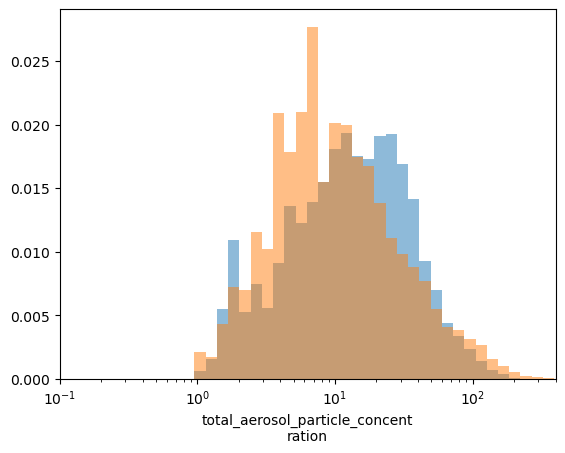

In [42]:
Nx_cloudresidual=data1_cl_mask.total_aerosol_particle_concentration

#resampling obs to hourly data
Nx_cloudresidual_hourly=Nx_cloudresidual.resample(time='H').mean()



#Plotting histograms of NorESM incloud droplet number and cloudmasked fogmonitor droplet number
ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
Nx_cloudresidual_hourly.plot.hist(bins=np.logspace(-1,3,50), alpha=.5, density=True)
plt.xscale('log')
plt.xlim([0.1,400])

## Seasons

### NorESM

In [43]:
ds_seasons = ds.groupby('time.season')

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 400)

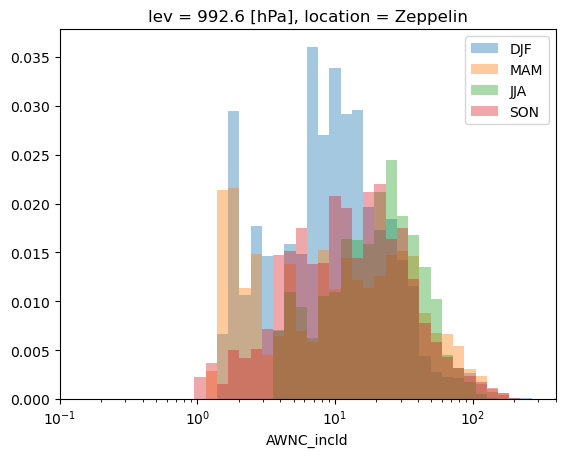

In [44]:
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    ds_seasons[s].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4, bins=np.logspace(-1,3,50), label=s)
    
plt.legend()

plt.xscale('log')
plt.xlim([0.1,400])

### Cloud residual

In [45]:
Nx_cloudresidual_seasons = Nx_cloudresidual_hourly.groupby('time.season')

(0.1, 400)

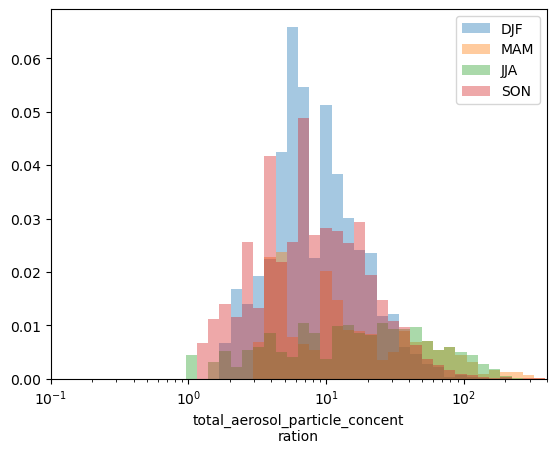

In [46]:
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    Nx_cloudresidual_seasons[s].plot.hist(density=True,alpha=0.4, bins=np.logspace(-1,3,50), label=s)
    
plt.legend()

plt.xscale('log')
plt.xlim([0.1,400])

### (icefree) Cloud droplets from fog monitor

In [47]:
Nx_cloud_icefree_seasons = Nx_cloud_icefree_hourly.groupby('time.season')

(0.1, 400)

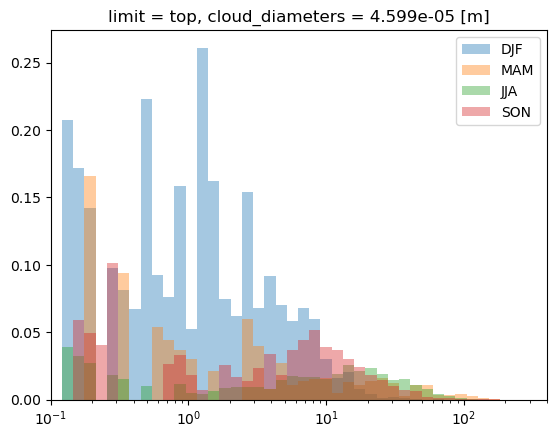

In [48]:
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    Nx_cloud_icefree_seasons[s].plot.hist(density=True,alpha=0.4, bins=np.logspace(-1,3,50), label=s)
    
plt.legend()

plt.xscale('log')
plt.xlim([0.1,400])

# Histogram subplots in seasons

In [49]:
# Load droplet number data from NorESM, GSVI and fog monitor

Nx_cloudresidual_seasons = Nx_cloudresidual_hourly.groupby('time.season')
ds_seasons = ds.groupby('time.season')
Nx_cloud_icefree_seasons = Nx_cloud_icefree_hourly.groupby('time.season')

season_str=['DJF', 'MAM', 'JJA', 'SON']


### Try to make a nice plot with Theos tutorial

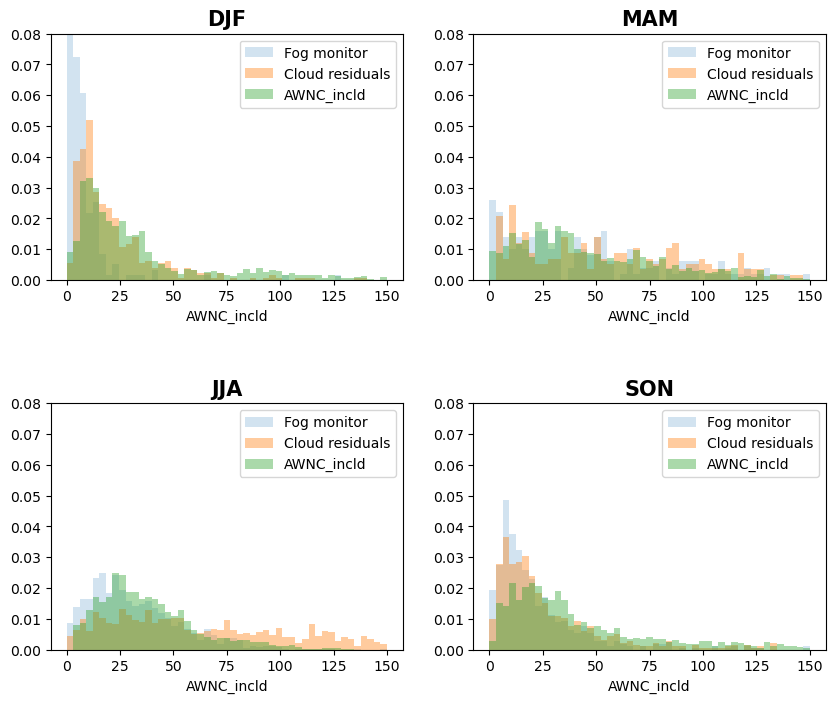

In [59]:
# define a figure and choose the size
fig = plt.figure(figsize=(10, 8))

# create the grid using plt.subplots
# nrows = 3, ncols = 4
for n_ax in range(0, 4):
    ax = plt.subplot(2, 2, n_ax + 1)
    
    #hide_ticks(ax)
    
    Nx_cloud_icefree_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.2, bins=np.linspace(0,150,50), label='Fog monitor')
    Nx_cloudresidual_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), label='Cloud residuals')
    ds_seasons[season_str[n_ax]].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), label='AWNC_incld')
    
    plt.legend()
    #plt.xscale('log')
    #plt.xlim([0.1,400])
    plt.ylim([0,0.08])
    ax.set_title(season_str[n_ax], fontweight='bold', fontsize=15)
    #bins=np.logspace(-1,3,50)
# adjust the spacing between subplots: wspace for width and hspace for height
plt.subplots_adjust(wspace=0.2, hspace=0.5)

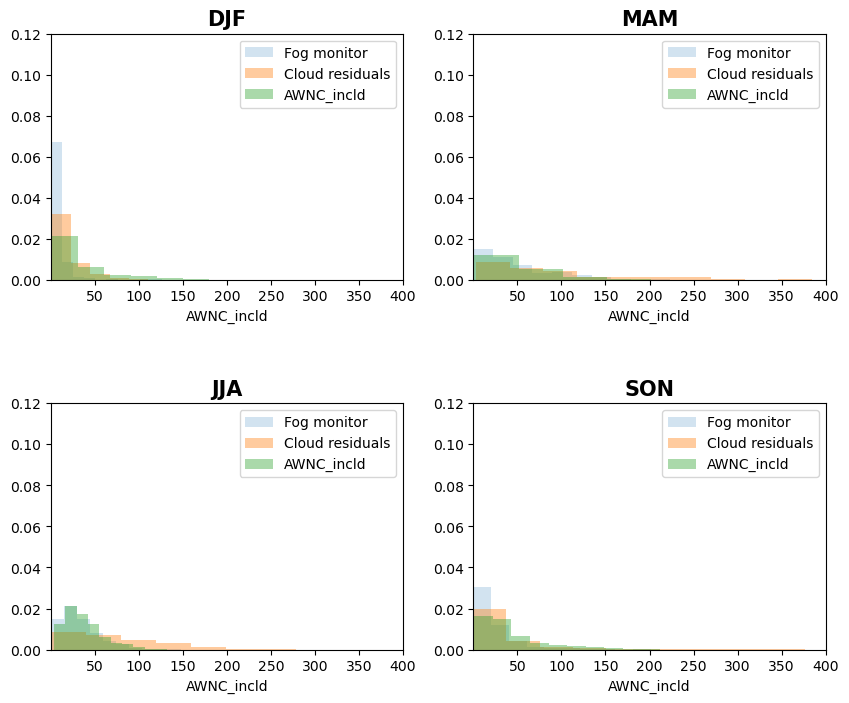

In [60]:
# define a figure and choose the size
fig = plt.figure(figsize=(10, 8))

# create the grid using plt.subplots
# nrows = 3, ncols = 4
for n_ax in range(0, 4):
    ax = plt.subplot(2, 2, n_ax + 1)
    
    #hide_ticks(ax)
    
    Nx_cloud_icefree_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.2, label='Fog monitor')
    Nx_cloudresidual_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.4,  label='Cloud residuals')
    ds_seasons[season_str[n_ax]].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4,  label='AWNC_incld')
    
    plt.legend()
    #plt.xscale('log')
    plt.xlim([0.1,400])
    plt.ylim([0,0.12])
    ax.set_title(season_str[n_ax], fontweight='bold', fontsize=15)

# adjust the spacing between subplots: wspace for width and hspace for height
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Scatter plots: N100 --> droplet concentration

In [63]:
# Calculate N100 and N50 from all_air inlet (data2) aerosol particle size distribution, by integrating above 100 and 50

N100_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=100e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N50_allair=compute_Nx_ebas_cleaned(data1_cl_mask,x=50e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')


In [64]:
# Make daily means 

N100_allair_daily = N100_allair.resample(time='D').mean()
N50_allair_daily = N50_allair.resample(time='D').mean()
Nx_cloud_daily = Nx_cloud.resample(time='D').mean()
ds_daily = ds.resample(time='D').mean()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [65]:
# Merging obs. variables to get droplet number and particle number in one

N100_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N100_allair_daily.rename('N100_allair')])
N50_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N50_allair_daily.rename('N50_allair')])

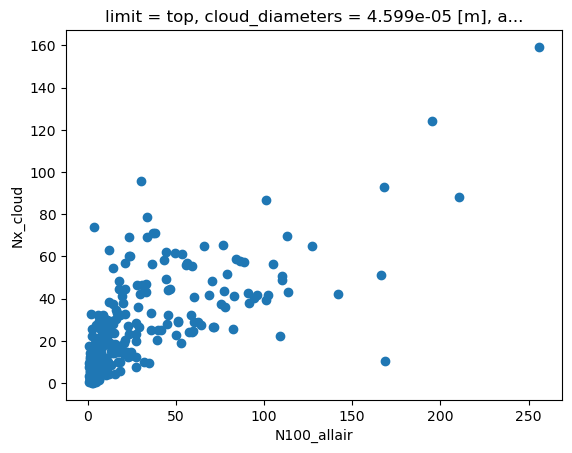

In [206]:
N100_daily.plot.scatter('N100_allair', 'Nx_cloud')

In [66]:
N50_daily_nonan=N50_daily.dropna('time')

model = LinearRegression().fit(N50_daily_nonan.N50_allair.data.reshape(-1,1), N50_daily_nonan.Nx_cloud)
rs=model.score(N50_daily_nonan.N50_allair.data.reshape(-1,1), N50_daily_nonan.Nx_cloud)
rs

0.5520286300212757

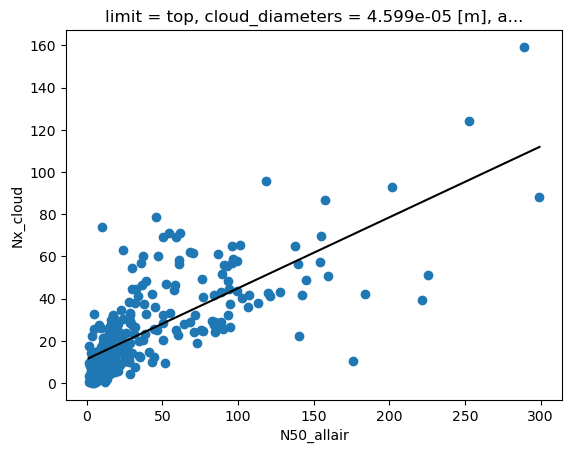

In [274]:
N50_daily.plot.scatter('N50_allair','Nx_cloud')
z = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloud'],1)
p = np.poly1d(z)
x=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
plt.plot(x, p(x), c='k')
#plt.xscale('log')
#plt.yscale('log')

In [68]:
N100_daily_nonan=N100_daily.dropna('time')

model = LinearRegression().fit(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloud)
rs=model.score(N100_daily_nonan.N100_allair.data.reshape(-1,1), N100_daily_nonan.Nx_cloud)
rs


0.49640575338095505

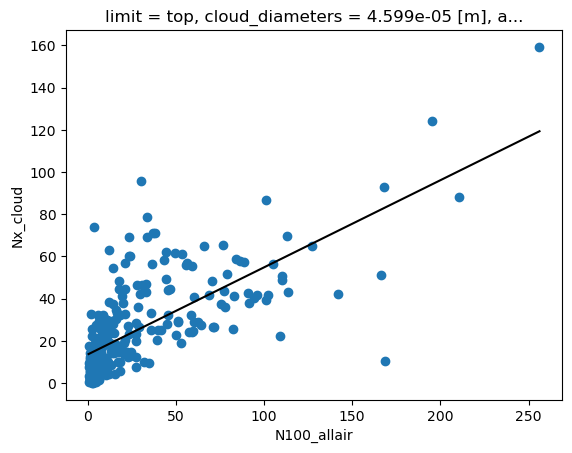

In [69]:
N100_daily.plot.scatter('N100_allair','Nx_cloud')
z = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloud'],1)
p = np.poly1d(z)
x=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
plt.plot(x, p(x), c='k')
#plt.xscale('log')
#plt.yscale('log')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, '#/cm3')

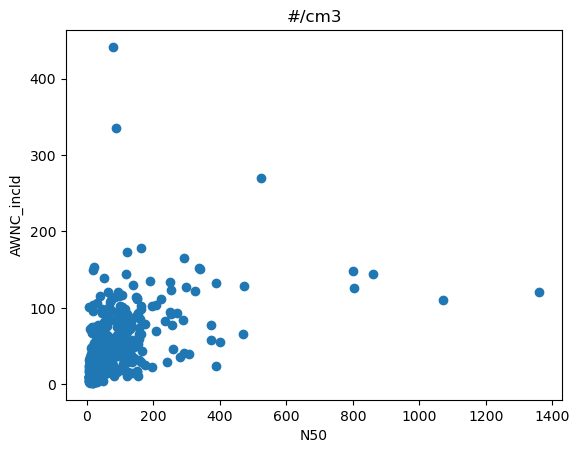

In [191]:
ds_daily.isel(lev=-1).sel(location='Zeppelin').plot.scatter('N50', 'AWNC_incld')

#y= np.polyfit(ds_daily.N50, ds_daily.AWNC_incld,1)
#p=np.poly1d(z)
plt.title('#/cm3')

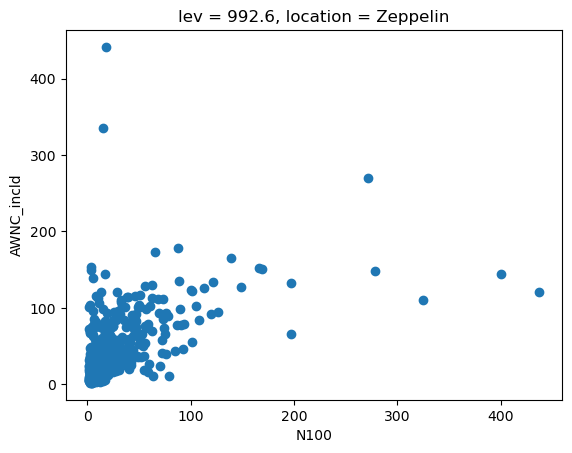

In [186]:
ds_daily.isel(lev=-1).sel(location='Zeppelin').plot.scatter('N100', 'AWNC_incld')